# HW4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex

# set path
import os
os.chdir('%s/courses/coursera_ml008/hw4' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

%matplotlib inline
# plotting options
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw4


## 1 Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

#### load data

In [2]:
data = scipy.io.loadmat('ex4data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X_orig = data['X']
y_true = data['y']
y_true = np.where(y_true==10, 0, y_true)
X_orig.shape, y_true.shape

((5000, 400), (5000, 1))

In [4]:
m, n = X_orig.shape
m, n

(5000, 400)

### 1.1 Visualizing the Data

#### function to display the data

In [5]:
def diplay_data(X, ax=None, seed=1):
    image = np.zeros((10*20, 10*20))
    random.seed(seed)
    for i in np.arange(100):
        row       = i/10
        col       = i%10
        row_begin = row*20
        row_end   = (row+1)*20
        col_begin = col*20
        col_end   = (col+1)*20
        idx       = random.uniform(0,m)
        image[row_begin:row_end,:][:,col_begin:col_end] = X[idx].reshape(20,20).T

    if ax is None:
        ax = plt.subplot()
    ax.imshow(image, cmap='Greys')
    ax.axis('off')

#### show random data

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


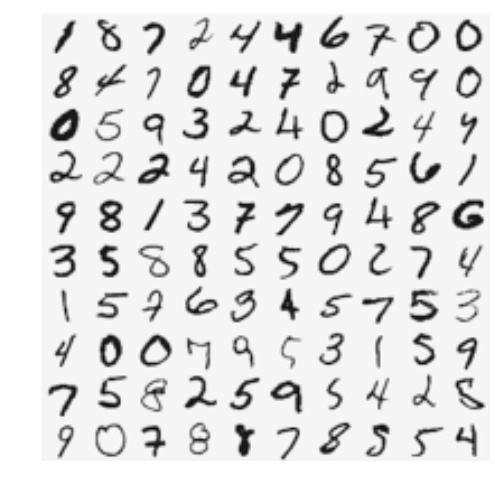

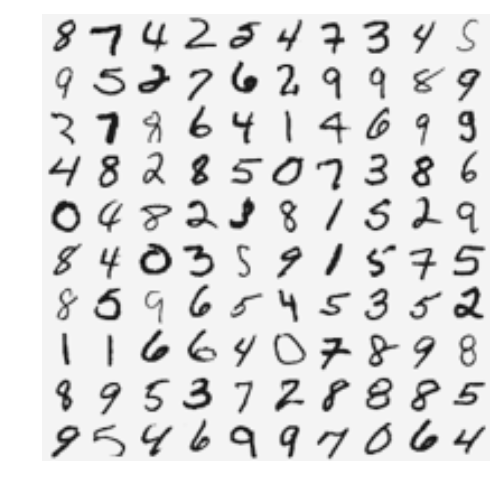

In [6]:
diplay_data(X_orig)
plt.show()
diplay_data(X_orig, seed=0)
plt.show()

This is the same dataset that you used in the previous exercise. There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is \unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

\begin{align}
{\bf X} = 
\left( 
\begin{array}{c}
-\ {{\bf x}^{(1)} }^T - \\
-\ {{\bf x}^{(2)} }^T - \\
\vdots  \\
-\ {{\bf x}^{(m)} }^T - \\
\end{array} 
\right)
\end{align}

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

In [7]:
X_orig.shape, y_true.shape

((5000, 400), (5000, 1))

### 1.2 Model Representation

Our neural network is shown in Figure 2. It has 3 layers--an input layer,a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 $\times$ 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1).

<img src="fig2.png" width=500/>

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in *ex4weights.mat* and will be loaded into *Theta1* and *Theta2*. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

#### loading parameters

In [8]:
params = scipy.io.loadmat('ex4weights.mat')
theta1 = params['Theta1']
theta2 = params['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

### 1.3 Feedforward and const function

Now you will implement the cost function and gradient for the neural network. First, complete the code in nnCostFunction.m to return the cost. Recall that the cost function for the neural network (without regularization) is

\begin{align}
    J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}
    \left[
        - y_k^{(i)}\log\left\{(h_{\theta}(x^{(i)})))_k\right\}
        - (1 - y_k^{(i)})\log\left\{1-(h_{\theta}(x^{(i)})))_k\right\}
    \right] 
    \text{,}
\end{align}

where $h_{\theta}(x^{(i)})$ is computed as shown in the Figure 2 and $K = 10$ is the total number of possible labels. Note that $h_{\theta}(x^{(i)})_k = a^{(3)}_k$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that

\begin{align}
y = 
\left[
\begin{array}{c}
1      \\
0      \\
0      \\
\vdots \\
0      \\
\end{array} 
\right], 
\space
\left[
\begin{array}{c}
0      \\
1      \\
0      \\
\vdots \\
0      \\
\end{array} 
\right], 
\space
\text{or}
\left[
\begin{array}{c}
0      \\
0      \\
0      \\
\vdots \\
1      \\
\end{array} 
\right].
\end{align}

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_{\theta}(x^{(i)})$ for every example i and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \geq 3$ labels).

In [9]:
y_vec = np.zeros((m,10))
y_vec.shape, y_vec

((5000, 10), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [10]:
for row in np.arange(m):
    y_vec[row, y_true[row]] = 1
y_vec.shape

(5000, 10)

In [11]:
y_vec

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [12]:
def g(z):
    return 1.0/(1 + np.exp(-z))

In [13]:
def h(theta, X):
    X     = np.asmatrix(X)
    theta = np.asmatrix(theta)
    z     = X*theta.T
    return g(z)

In [14]:
def h_nn(theta1, theta2, X, shift_idx=True):
    m, n = X.shape
    
    # layer 1
    a1 = np.concatenate((np.ones((m,1)), X), axis=1)
    
    # layer 2
    a2 = h(theta1, a1)
    
    # layer 3
    a2 = np.concatenate((np.ones((m,1)), a2), axis=1)
    a3 = h(theta2, a2)
    
    # shift index due to thetas being 
    # trained by octave convention
    if shift_idx:
        a3 = np.roll(a3, shift=1, axis=1)
    
    # probability
    return np.asarray(a3)

In [15]:
prob = h_nn(theta1, theta2, X_orig)
prob.shape

(5000, 10)

In [16]:
pred = np.argmax(np.asmatrix(prob), axis=1)
pred = np.where(pred==10, 0, pred)
pred

array([[0],
       [0],
       [0],
       ..., 
       [9],
       [9],
       [9]])

In [17]:
accuracy = np.mean((pred==y_true)*100)
accuracy

97.519999999999996

In [18]:
def cost_nn(theta1, theta2, X, y, K=10):  
    h_value  = h_nn(theta1, theta2, X)
    y        = np.asarray(y)
    J        = (1.0/m)*np.sum(-y*np.log(h_value) - (1-y)*np.log(1-h_value))
    return J

Once you are done, ex4.m will call your *cost_nn* using the loaded set of parameters for *Theta1* and *Theta2*. You should see that the cost is about 0.287629

In [19]:
cost_nn(theta1, theta2, X_orig, y_vec, K=10)

0.28762916516131892

### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by

\begin{align}
    J(\theta) =& \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}
    \left[
        - y_k^{(i)}\log\left\{(h_{\theta}(x^{(i)})))_k\right\}
        - (1 - y_k^{(i)})\log\left\{1-(h_{\theta}(x^{(i)})))_k\right\}
    \right] + \\
    & 
    \frac{\lambda}{2m}
    \left[
        \sum_{j=1}^{25}\sum_{k=1}^{400}\left( \Theta_{j,k}^{(1)}\right)^2 + 
        \sum_{j=1}^{10}\sum_{k=1}^{ 25}\left( \Theta_{j,k}^{(2)}\right)^2
    \right]    
    \text{.}
\end{align}

You can assume that the neural network will only have 3 layers: an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size.

Note that you should not be regularizing the terms that correspond to the bias. For the matrices **`Theta1`** and **`Theta2`**, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function J using your existing *cost_nn* and then later add the cost for the regularization terms.

Once you are done, call your cost function using the loaded set of parameters for **`Theta1`** and **`Theta2`**, and $\lambda$ = 1. You should see that the cost is about 0.383770.

In [20]:
def cost_nn(theta1, theta2, X, y, K=10, lambda_param=0.0):
    h_value  = h_nn(theta1, theta2, X)
    y        = np.asarray(y)
    J        = (1.0/m)*np.sum(-y*np.log(h_value) - (1-y)*np.log(1-h_value))
    J       += (lambda_param/(2*m))*(np.sum(theta1[...,1:]**2) + np.sum(theta2[...,1:]**2))
    return J

In [21]:
cost_nn(theta1, theta2, X_orig, y_vec, K=10, lambda_param=1.0)

0.38376985909092365

## 2 Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the cost function so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\Theta)$ using an advanced optimizer such as fmincg.

You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

### 2.1 Sigmoid Gradient

To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

\begin{align}
    g'(z) = \frac{d}{dz} g(z) = g(z)(1-g(z))
\end{align}

where

\begin{align}
    \operatorname{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}}
\end{align}
 
￼When you are done, try testing a few values by calling sigmoidGradient(z) at the Octave/MATLAB command line. For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [22]:
def g_prime(z):
    is_matrix = isinstance(z, np.matrix)
    if is_matrix:
        z = np.asarray(z)
    g_z = g(z)
    result = g_z*(1-g_z)
    if is_matrix:
        result = np.asmatrix(result)
    return result

In [23]:
g_prime(np.array([-5, -0.1, 0, 0.1, 5]))

array([ 0.007,  0.249,  0.25 ,  0.249,  0.007])

In [24]:
g_prime(np.matrix([-5, -0.1, 0, 0.1, 5]))

matrix([[ 0.007,  0.249,  0.25 ,  0.249,  0.007]])

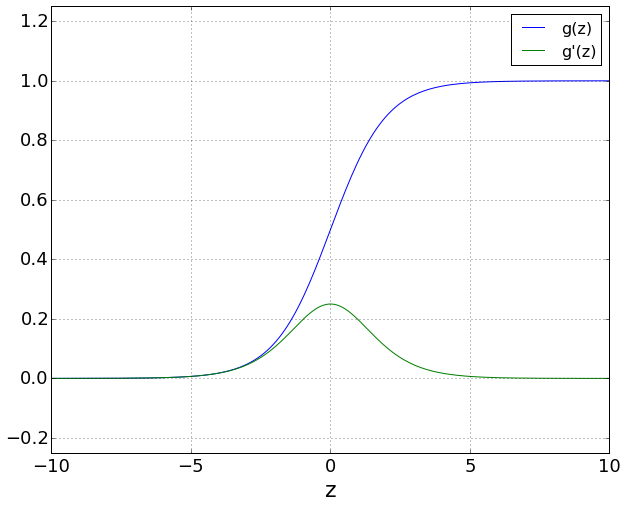

In [25]:
z = np.linspace(-50, 50, 1000)
plt.plot(z, g(z), z, g_prime(z))
plt.axis([-10, 10, -0.25, 1.25])
plt.xlabel("z")
plt.legend(['g(z)', 'g\'(z)'])
plt.grid()
plt.show()

### 2.2 Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(1)}$ uniformly in the range $[−\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

Your job is to complete randInitializeWeights.m to initialize the weights for $\Theta$; modify the file and fill in the following code:

￼￼`% Randomly initialize the weights to small values
epsilon init = 0.12;
W = rand(L out, 1 + L in) * 2 * epsilon init − epsilon init;`

**note**:
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is 

\begin{align}
\epsilon_{init} = \sqrt{\frac{6}{L_{in} + L_{out}}}
\end{align}, 

where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$.

In [26]:
def rand_initialize_weights(L_in, L_out, seed=1):
    np.random.seed(seed)
    eps    = np.sqrt(6.0/float(L_in + L_out))
    result = np.random.rand(L_out, L_in+1)*2*eps - eps
    return result

In [27]:
rand_initialize_weights(3,4)

array([[-0.154,  0.408, -0.926, -0.366],
       [-0.654, -0.755, -0.581, -0.286],
       [-0.191,  0.072, -0.15 ,  0.343],
       [-0.547,  0.7  , -0.875,  0.316]])

### Backpropagation

<img src="fig3.png" width=600/>

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)},y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the
hypothesis $h_{\Theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta^{(l)}_j$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta^{(3)}_j$
(since layer 3 is the output layer). For the hidden units, you will compute $\delta^{(l)}_j$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

In detail, here is the backpropagation algorithm (also depicted in Figure 3). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for `t = 1:m` and place steps 1-4 below inside the for-loop, with the $t^{\rm th}$ iteration performing the calculation on the tth training example $(x^{(t)},y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the t-th training example $x^{(t)}$. Perform a feedforward pass (Figure 2), computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add $a+1$ term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In Octave/MATLAB, if a 1 is a column vector, adding one corresponds to `a1 = [1 ; a1]`.

1. For each output unit k in layer 3 (the output layer), set $$\delta^{(3)}_k = (a^{(3)}_k − y_k)$$, where $y_k \in {0,1}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l$ = 2, set $$\delta^{(2)} = \left(\Theta^{(2)}\right)^T  \delta^{(3)} \cdot g′(z^{(2)})$$

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta^{(2)}_0$. In Octave/MATLAB, removing $\delta^{(2)}_0$ corresponds to `delta_2 = delta_2(2:end)`. $$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} \left(a^{(l)}\right)^T$$

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:

\begin{align}
\frac{\partial}{\partial\Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta^{(l)}_{ij}.
\end{align}

In [28]:
theta1_rand = np.asmatrix(rand_initialize_weights(400, 25))
theta2_rand = np.asmatrix(rand_initialize_weights(25 , 10))
theta1_rand.shape, theta2_rand.shape

((25, 401), (10, 26))

In [29]:
def grad_nn(theta1, theta2, X, y, K=10):  

    m, n   = X.shape
    theta1 = np.asmatrix(theta1)
    theta2 = np.asmatrix(theta2)

    def prepend_zeros(a):
        #return np.roll(np.append(a, 0), shift=1, axis=0)
        return np.roll(np.concatenate([a, np.asmatrix(np.zeros((1,1)))], axis=1), shift=1)
    
    Delta_1 = np.zeros_like(theta1)
    Delta_2 = np.zeros_like(theta2)
    
    for t in np.arange(m):
        x_t = np.asmatrix(X[t])
        y_t = np.asmatrix(y[t])
        
        #--------------------------------- #
        # step 1: forward propagation
        #--------------------------------- #
        
        # layer 1
        a_1 = prepend_zeros(x_t)
        
        # layer 2
        z_2 = a_1*theta1.T
        a_2 = h(theta1, a_1)
        a_2 = np.asmatrix(a_2)
        a_2 = prepend_zeros(a_2)
        
                
        # layer 3
        #z_3 = a_2*theta2.T
        a_3 = h(theta2, a_2)
        a_3 = np.asmatrix(a_3)
                
        #--------------------------------- #
        # step 2: compute delta3
        #--------------------------------- #
        
        delta_3 = a_3 - y_t
        
        #--------------------------------- #
        # step 3: compute delta2
        #--------------------------------- #
        
        delta_2 = np.multiply((delta_3*theta2)[...,1:], g_prime(z_2))
        
        #--------------------------------- #
        # step 4: compute Delta
        #--------------------------------- #
        
        Delta_1 = Delta_1 + delta_2.T*a_1
        Delta_2 = Delta_2 + delta_3.T*a_2

    #--------------------------------- #
    # step 5: compute Grad_J
    #--------------------------------- #
    
    grad_J_1 = Delta_1/float(m)
    grad_J_2 = Delta_2/float(m)

    return grad_J_1, grad_J_2

In [30]:
grad_J_1, grad_J_2 = grad_nn(theta1_rand, theta2_rand, X_orig, y_vec, K=10)
grad_J_1.shape, grad_J_2.shape

((25, 401), (10, 26))

## 2.4 Gradient Checking

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\Theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; ￼you’d like to check if $f_i$ is outputting correct derivative values.

\begin{align}
\text{Let } \space \theta^{(i+)} = \theta + 
\left[
\begin{array}{c}
0        \\
0        \\
\vdots   \\
\epsilon \\
\vdots   \\
0        \\
\end{array} 
\right], 
\space
\text{ and }
\space
\theta^{(i-)} = \theta - 
\left[
\begin{array}{c}
0        \\
0        \\
\vdots   \\
\epsilon \\
\vdots   \\
0        \\
\end{array} 
\right]
\end{align}

So, $\theta^{(i+)}$ is the same as $\theta$, except its the i-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the i-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each i, that:

\begin{align}
f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}
\end{align}

The degree to which these two values should approximate each other will depend on the details of J. But assuming $\epsilon = 10^{−4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in computeNumericalGradient.m. While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works. 

In the next step of ex4.m, it will run the provided function checkNNGradients.m which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct, you should see a relative difference that is less than `1e-9`.

In [31]:
# deterministic inital weights
def debug_initial_weights(L_in, L_out):
    W = np.sin(np.arange(1,(L_out*(L_in+1))+1)).reshape((L_out, L_in+1))/10
    return W

In [32]:
theta1_debug = debug_initial_weights(400, 25)
theta2_debug = debug_initial_weights(25 , 10)
theta1_debug.shape, theta2_debug.shape

((25, 401), (10, 26))

In [33]:
def compute_numerical_grad(f, theta):
    theta   = np.asarray(theta)
    grad    = np.empty_like(theta)
    perturb = np.zeros_like(theta)
    eps     = 1e-4
    
    for i in np.arange(theta.size):
        perturb[i] = eps
        grad[i]    = (f(theta + perturb) - f(theta - perturb))/(2*eps)
        perturb[i] = 0
        
    return np.array(grad)

In [34]:
def roll_params(theta1, theta2):
    theta1 = np.asarray(theta1)
    theta2 = np.asarray(theta2)
    return np.concatenate([theta1.ravel(), theta2.ravel()])

def unroll_params(theta, shape1, shape2):
    size1  = shape1[0]*shape1[1]
    theta1 = theta[:size1].reshape(shape1)
    theta2 = theta[size1:].reshape(shape2)
    return theta1, theta2    

In [35]:
def check_nn_grads(lambda_param = 0.0):
    
    # parameters of the NN
    num_input_layers  = 3
    num_hidden_layers = 5
    num_labels        = 3
    m                 = 5
    
    # generate 'random' test data
    theta1 = debug_initial_weights(num_input_layers , num_hidden_layers)
    theta2 = debug_initial_weights(num_hidden_layers, num_labels)
    X      = debug_initial_weights(num_input_layers-1, m)
    y      = 1 + np.mod(np.arange(1, m+1), num_labels)
    
    y_vec = np.empty((m,num_labels))
    for row in np.arange(m):
        y_vec[row, y[row]-1] = 1
    
    # unroll theta
    theta = roll_params(theta1, theta2)
    
    # cost/grad
    cost             = cost_nn(theta1, theta2, X, y_vec, K=num_labels, lambda_param=lambda_param)
    grad_J1, grad_J2 = grad_nn(theta1, theta2, X, y_vec, K=num_labels)
    grad             = roll_params(grad_J1, grad_J2)
    
    # numerical grad
    def cost_wrapper(flat_theta):
        th1, th2 = unroll_params(flat_theta, theta1.shape, theta2.shape)
        return cost_nn(th1, th2, X, y_vec, K=num_labels, lambda_param=lambda_param)
        
    num_grad = compute_numerical_grad(cost_wrapper, theta)
    
    # print shapes
    print("shapes:")
    print(grad.shape, num_grad.shape)
    
    # diff
    diff = np.linalg.norm(num_grad - grad)/np.linalg.norm(num_grad + grad)
    print("diff:")
    print(diff)
    
    return

In [36]:
check_nn_grads()

shapes:
((38,), (38,))
diff:
1.00020377481
